In [ ]:
%matplotlib inline
import sys
import errno
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Global variables that sets the type of coin evaluated, prediction distance, the range the volatility is calculated from, and the total number of the total 

In [62]:
# _coin_type = "bitcoin"
_volatility_range = 6
_change_flex = 0.5

Pulls the data from the appropriate url and saves it as a data frame

In [63]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [64]:
all_data = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
all_data['ds'] = pd.to_datetime(all_data['date'], unit='s')

Prints frame data

In [65]:
all_data.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
count,156.000000,1.560000e+02,156.000000,156.000000,156.000000,156.000000,1.560000e+02,156.000000
mean,5843.356586,1.510445e+09,6047.444060,5562.827601,5837.816520,6670.125353,3.402967e+07,5800.606595
std,3985.250917,1.561332e+07,4181.506590,3732.305769,4008.118330,7633.965720,4.276945e+07,3941.334865
min,817.477031,1.483661e+09,836.040000,801.975002,827.000000,357.188021,3.275330e+05,823.940432
25%,2341.723565,1.497053e+09,2455.393125,2138.874750,2384.085532,1431.489282,7.491706e+06,2314.256432
50%,6246.499759,1.510445e+09,6381.192780,6017.187241,6248.500000,4881.101939,1.849192e+07,6239.916909
75%,8203.411391,1.523837e+09,8345.464390,7942.972317,8122.000000,8747.166912,4.405675e+07,8179.843662
max,19223.000000,1.537229e+09,19764.788462,17251.000000,17540.000000,46736.316469,2.345371e+08,18458.093899


Selects the appropriate amount of data from the full frame

In [66]:
df = all_data[['ds','close']]
df.columns = ['ds','price']
df['log'] = np.log(df['price'])
df['vol'] = df['log'].rolling(_volatility_range).mean()

Pulls the dates and prices from the data and creates the log and volatility columns

Shows statistics for the three columns

In [67]:
df.describe()

,price,log,vol
count,156.000000,156.000000,151.000000
mean,5843.356586,8.376794,8.396622
std,3985.250917,0.847266,0.828644
min,817.477031,6.706223,6.791356
25%,2341.723565,7.758636,7.804893
50%,6246.499759,8.739777,8.766092
75%,8203.411391,9.012305,8.994861
max,19223.000000,9.863863,9.669777


Displays kurtosis for the three data sources

Kurtosis for log and vol is relatively low indicating that there aren't many extrema.

In [68]:
df.kurtosis()

price    0.434905
log     -0.953769
vol     -0.963780
dtype: float64

Displays skew for the three data sources

The skew is positive meaning that that the the graph is asymmetric with a left weight

In [69]:
df.skew()

price    0.772330
log     -0.510625
vol     -0.535901
dtype: float64

Defines a method to extract and forecast the specified data stream

In [70]:
m = Prophet(changepoint_prior_scale = _change_flex)
df['y'] = df['vol']
m.fit(df)

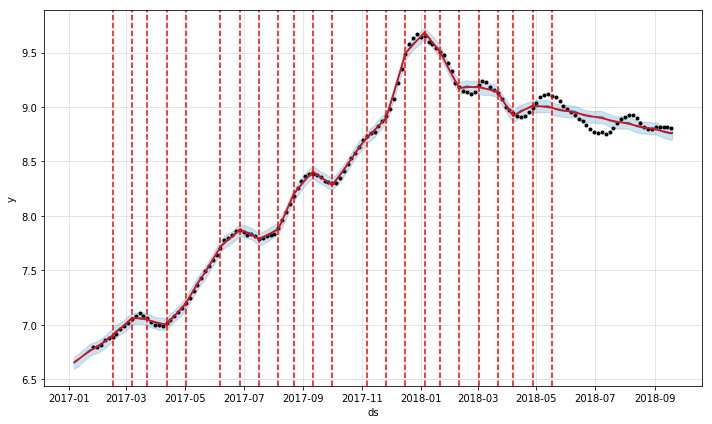

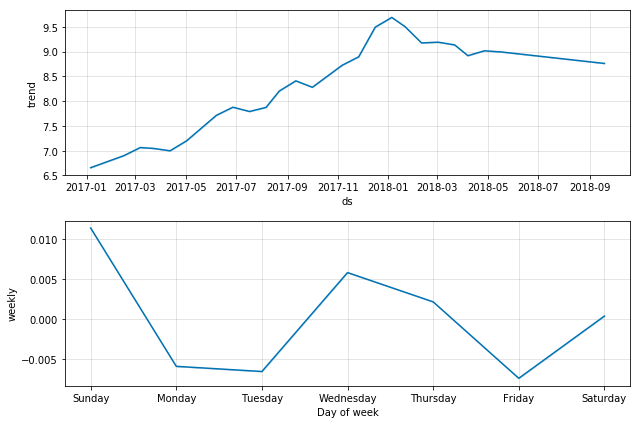

In [71]:
future = m.make_future_dataframe(periods=1)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

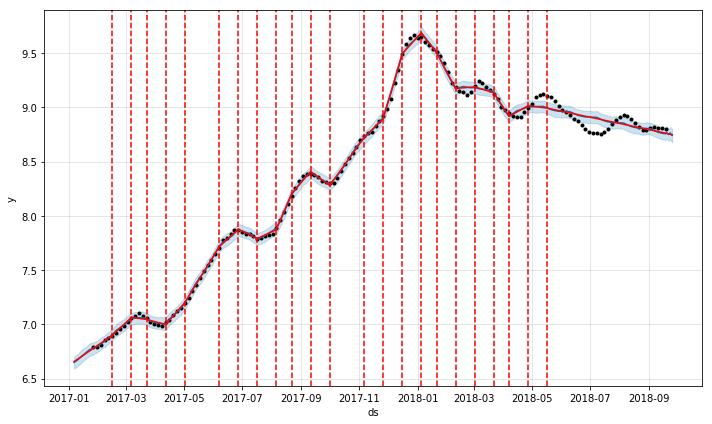

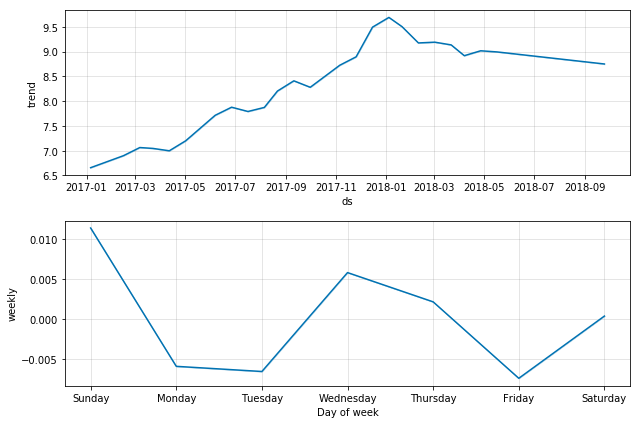

In [72]:
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

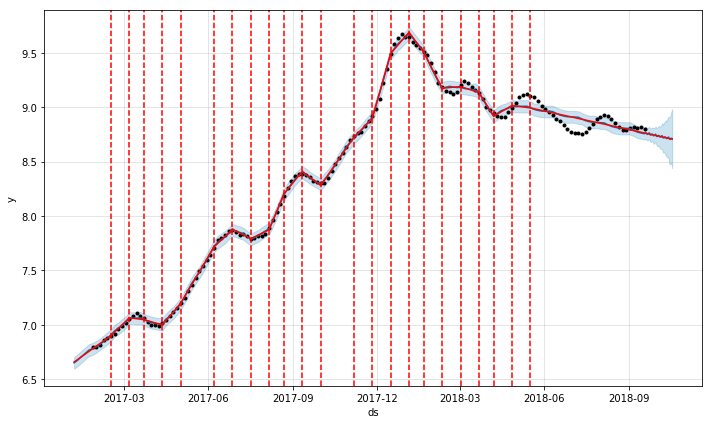

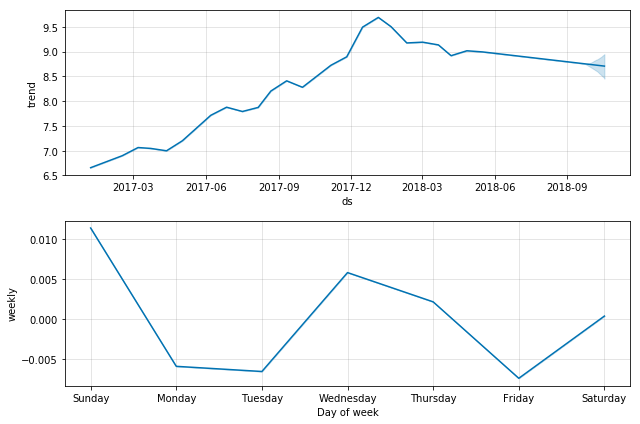

In [73]:
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

Defines method to plot the data with a red line and blue points overlayed

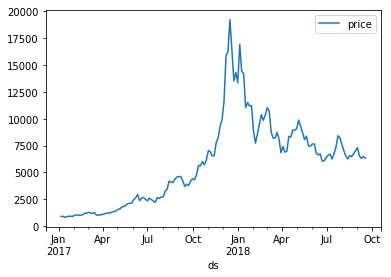

In [88]:
df.plot(x='ds', y ='price')

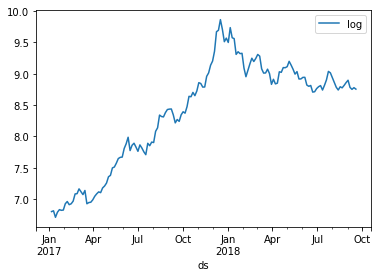

In [89]:
df.plot(x='ds', y ='log')

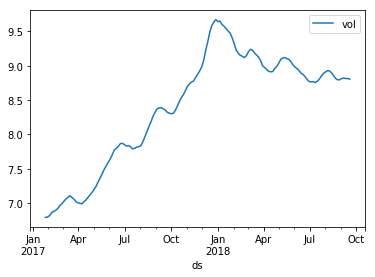

In [90]:
df.plot(x='ds', y ='vol')

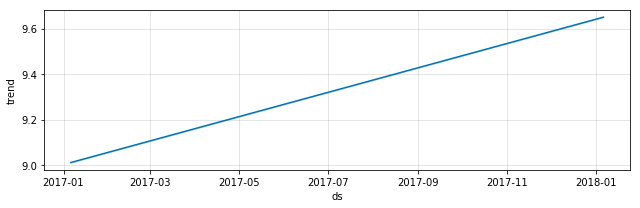

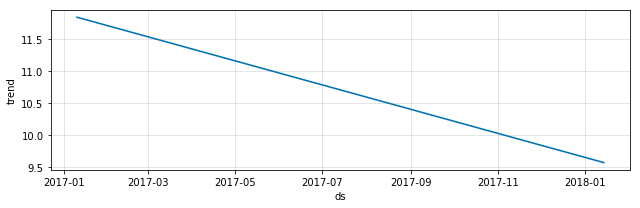

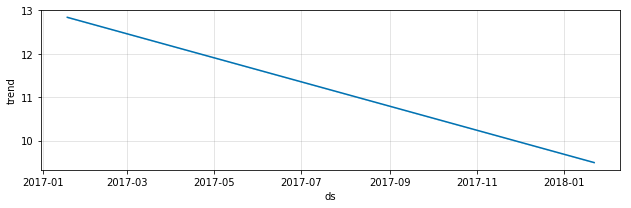

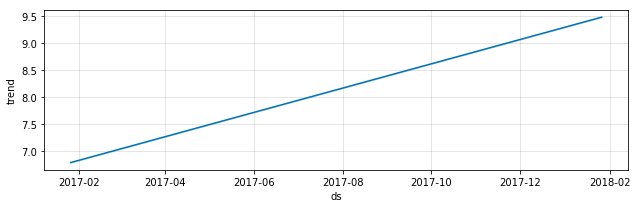

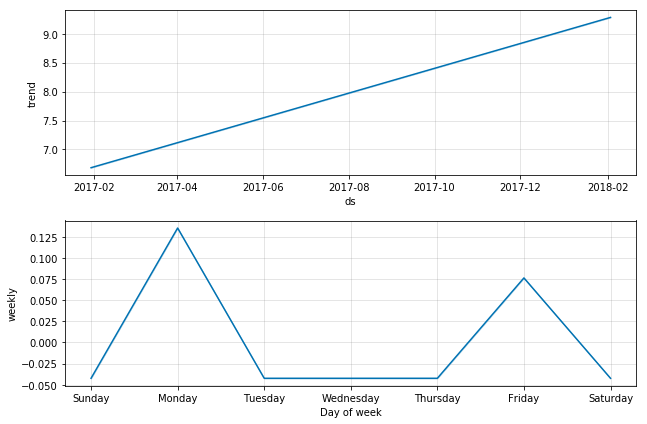

In [78]:
d = dict(tuple(df.groupby(df['ds'].dt.week)))
for i, df_week in d.items()[:5]:
    m = Prophet()
    m.fit(df_week)
    future = m.make_future_dataframe(periods=1)
    future.tail()
    forecast = m.predict(future)
    fig2 = m.plot_components(forecast)